In [1]:
from pathlib import Path
from docile.dataset import Dataset, KILE_FIELDTYPES, LIR_FIELDYPES
from collections import Counter


In [2]:

DATASET_PATH = Path("/shared/ailabs/pif_documents/dataset_exports/docile221221-0/")
PRETRAINING_DATASET_PATH = Path("/shared/ailabs/pif_documents/dataset_exports/docile_pretraining_v1_2022_12_22/")

dataset_train = Dataset.from_file("train.json", DATASET_PATH)
dataset_val = Dataset.from_file("val.json", DATASET_PATH)
dataset_pretrain = Dataset.from_file("pretraining-all.json", PRETRAINING_DATASET_PATH)

Loading documents for docile221221-0/val.json: 100%|██████████| 500/500 [00:00<00:00, 1001.94it/s]
Loading documents for docile_pretraining_v1_2022_12_22/pretraining-all.json: 100%|██████████| 932467/932467 [13:33<00:00, 1146.83it/s]


In [3]:

def npages(dataset):
    page_counter = Counter([d.page_count for d in dataset])
    
    total = page_counter.total()
    pages = [page_counter[i] for i in range(1, max(page_counter.keys())+1)]
    pages_ratio = [p/total for p in pages]
    return pages, pages_ratio

pages_train, pages_ratio_train = npages(dataset_train)
pages_val, pages_ratio_val = npages(dataset_val)
pages_pretrain, pages_ratio_pretrain = npages(dataset_pretrain)


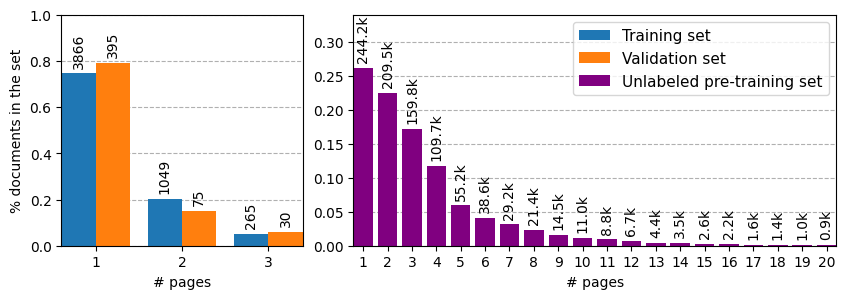

In [12]:
import matplotlib.pyplot as plt
import numpy as np


fig, (ax1, ax2) = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 2], 'wspace': 0.14})
fig.set_figwidth(10)
fig.set_figheight(3)
bar_train = ax1.bar(np.arange(len(pages_train))+0.8, pages_ratio_train, width=.4, label="Training set")
ax1.bar_label(bar_train, pages_train, rotation=90, padding=4)
bar_val = ax1.bar(np.arange(len(pages_val))+1.2, pages_ratio_val, width=.4, label="Validation set")
ax1.bar_label(bar_val, pages_val, rotation=90, padding=4)
x_axis = np.arange(1, 4)
ax1.set_xticks(x_axis)
ax1.set_xlim(min(x_axis)-.4, max(x_axis)+.4)
ax1.set_ylim(0,1)
ax1.set_ylabel("% documents in the set")
ax1.set_xlabel("# pages")
ax1.set_axisbelow(True)
ax1.grid(True, axis="y", linestyle="dashed")
#plt.savefig("/app/figures/pages_trainval.pdf", bbox_inches='tight')


n_plot_pretrain = 20
bar_pretrain = ax2.bar(np.arange(n_plot_pretrain)+1, pages_ratio_pretrain[:n_plot_pretrain], width=.8, label="Unlabeled pre-training set", color="purple")
pretrain_labels = [ f"{p/1000:.1f}k" for p in pages_pretrain[:n_plot_pretrain] ]
ax2.bar_label(bar_pretrain, pretrain_labels,rotation=90, padding=4)
handles, labels = [(a + b) for a, b in zip(ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels())] 
ax2.legend(handles, labels, prop={'size': 11})
x_axis = np.arange(1, n_plot_pretrain+1)
ax2.set_xticks(x_axis)
ax2.set_xlim(min(x_axis)-.4, max(x_axis)+.4)
ax2.set_ylim(0,.34)
ax2.set_xlabel("# pages")
ax2.set_axisbelow(True)
ax2.grid(True, axis="y", linestyle="dashed")
plt.savefig("/app/figures/pages.pdf", bbox_inches='tight')

In [7]:
def docs_in_clusters(dataset):
    cluster_counter = Counter([d.annotation.content['metadata']['cluster_id'] for d in dataset])
    
    total = cluster_counter.total()
    clusters = [cluster_counter[key] for key in cluster_counter.keys()]
    clusters_ratio = [c/total for c in clusters]
    return clusters, clusters_ratio
clusters_train, clusters_ratio_train = docs_in_clusters(dataset_train)
clusters_val, clusters_ratio_val = docs_in_clusters(dataset_val)

In [8]:
train_cluster_counter = Counter([d.annotation.content['metadata']['cluster_id'] for d in dataset_train])
val_cluster_counter = Counter([d.annotation.content['metadata']['cluster_id'] for d in dataset_val])
trainval_cluster_counter = train_cluster_counter + val_cluster_counter

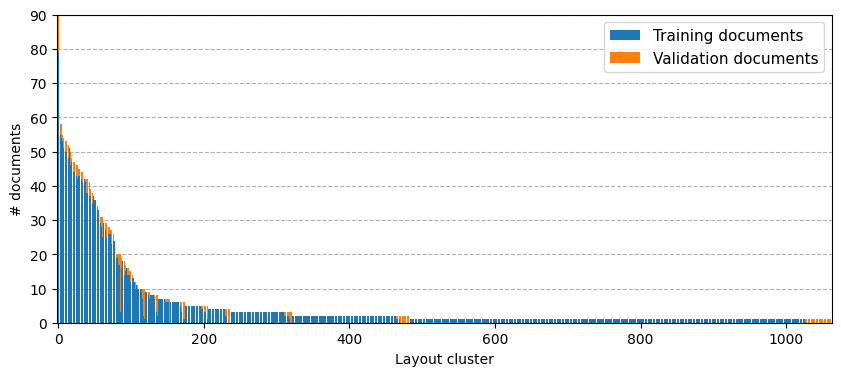

In [11]:
#cluster_ids = [cluster_id for cluster_id, num_docs in trainval_counter.most_common(display_clusters)]
cluster_ids = sorted(trainval_cluster_counter.keys(), key=lambda k: (-trainval_cluster_counter[k], -train_cluster_counter[k]))
display_clusters = len(cluster_ids)
cluster_ids=cluster_ids[:display_clusters]
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(4)
train_cluster_docs = [train_cluster_counter[i] for i in cluster_ids]
val_cluster_docs   = [val_cluster_counter[i] for i in cluster_ids]
x=np.arange(len(cluster_ids))
p1 = ax.bar(x, train_cluster_docs, label="Training documents")
p2 = ax.bar(x, val_cluster_docs, label="Validation documents", bottom=train_cluster_docs)
ax.set_xlim(-2, display_clusters)
ax.set_ylim(0, max(trainval_cluster_counter.values()))
ax.set_axisbelow(True)
ax.grid(True, axis="y", linestyle="dashed")
ax.legend(prop={'size': 11})
#ax.set_xticklabels("")
ax.set_ylabel("# documents")
ax.set_xlabel("Layout cluster")
plt.savefig("/app/figures/layout_docs.pdf", bbox_inches='tight')

In [32]:
cluster_size_thresholds = [1,3,5,10,20,30,40,50,max(trainval_cluster_counter.values())]

In [39]:
prev = -1
docs_in_cluster_sizes = {}
for s in cluster_size_thresholds:
    docs_in_size = sum([num_docs for cluster, num_docs in trainval_cluster_counter.items() if num_docs > prev and num_docs <= s])
    label = f"{prev+1}-{s}" if prev>=0 else str(s)
    docs_in_cluster_sizes[label] = docs_in_size
    prev = s

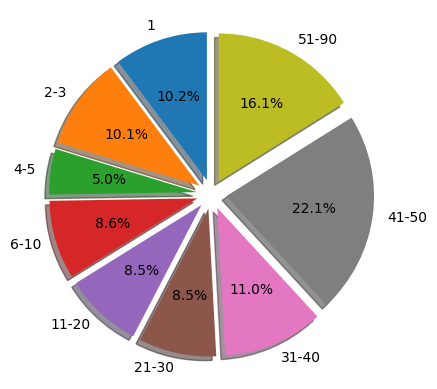

In [42]:
fig1, ax1 = plt.subplots()
ax1.pie(docs_in_cluster_sizes.values(), explode=[0.1]*len(cluster_size_thresholds),labels=docs_in_cluster_sizes.keys(), autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.savefig("/app/figures/docs_of_cluster_sizes.pdf", bbox_inches='tight')

In [6]:
doc = dataset_val[0]

In [25]:
def fields_in_dataset(dataset):
    field_counter = Counter()
    for doc in dataset:
        field_counter.update( list(f.fieldtype for f in doc.annotation.fields) )
    return field_counter

train_fieldtype_counter = fields_in_dataset(dataset_train)
val_fieldtype_counter = fields_in_dataset(dataset_val)
trainval_fieldtype_counter = train_fieldtype_counter + val_fieldtype_counter

In [28]:
len(dataset_train)+len(dataset_val)

5680

In [29]:
trainval_fieldtype_counter

Counter({'document_id': 6141,
         'date_issue': 6214,
         'customer_order_id': 626,
         'vendor_name': 7354,
         'vendor_address': 6634,
         'customer_id': 2108,
         'customer_billing_name': 6142,
         'customer_billing_address': 5249,
         'currency_code_amount_due': 4000,
         'amount_total_gross': 5966,
         'amount_due': 6125,
         'variable_symbol': 187,
         'payment_terms': 2295,
         'bank_num': 105,
         'account_num': 135,
         'date_due': 884,
         'customer_delivery_name': 378,
         'customer_delivery_address': 350,
         'amount_total_net': 838,
         'amount_total_tax': 654,
         'tax_detail_net': 519,
         'tax_detail_tax': 601,
         'tax_detail_gross': 542,
         'order_id': 3374,
         'vendor_tax_id': 760,
         'customer_other_name': 1463,
         'vendor_email': 648,
         'amount_paid': 432,
         'vendor_order_id': 233,
         'bic': 31,
         'customer